In [47]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # mpimg 用于读取图片
import torchvision
import torchvision.transforms as transforms

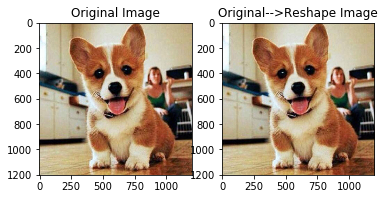

In [48]:
# 读取图片
dog = mpimg.imread('timg.jpg')
plt.subplot(121)
plt.imshow(dog)
plt.title('Original Image')
#形状reshape，测试是否可以在变换后进行还原到原来的图像上
dog = dog.reshape(1,3,1200,1200)
dog = dog.reshape(1200,1200,3)
plt.subplot(122)
plt.imshow(dog) #(1200,1200,3)
plt.title('Original-->Reshape Image')
plt.show()

In [49]:
def minmaxscaler(data):
    #像素值进行归一化
    min = np.min(data)
    max = np.max(data)    
    return (data - min)/(max-min)

# 测试一个随机的卷积对图像的处理效果

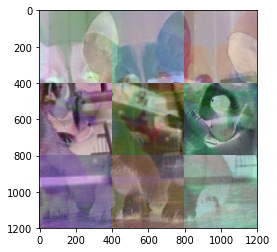

In [50]:
#将导入的图片规整为nn.conv2d()要求的输入：nSamples x nChannels x Height x Width
Dog = torch.FloatTensor(dog.reshape([1]+list(dog.shape[::-1])))
input_channels = Dog.shape[1]

#采用的是深度可分离卷积：Groups = in_channels
conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 3, kernel_size = 3, stride = 1, 
                  padding = 0, groups = input_channels)
Dog1 = conv1(Dog)
Dog1 = Dog1.reshape(Dog1.shape[1:][::-1]) #torch.Size([1198, 1198, 3])
Dog1 = Dog1.detach().numpy() #将一个Variable从创建它的图中分离,并把它设置成 leaf variable.
Dog1 = minmaxscaler(Dog1)*255 #将图片像素归一化到0-255之间
plt.imshow(Dog1.astype(int)) #将像素值转化为整数
plt.show()
# print(conv1.weight.shape) #权重 torch.Size([3, 1, 3, 3])


# 用conv2d-->maxpool-->relu处理可视化每层的结果
## 定义网络

In [51]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [52]:
def Print_image(image_Vadata):
    #输入是Variable数据类型，进行绘图
    data = image_Vadata.detach().numpy()

    #将普通的1*4[nSamples x nChannels x Height x Width]的np.array数组并进行
    #像素值归一化到0-255之间
    Image = data.reshape(data.shape[::-1][:-1])
    Image = minmaxscaler(Image)
    #绘图
    plt.imshow(Image)

def num_flat_features(x):
    size = x.size()[1:]  # 除批量维度外的所有维度
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

def in_linear(Input):
    #计算在卷积神经网络中的全连接层的输入大小
    conv = nn.Conv2d(3, 3, 5)
    x_maxpool1 = F.max_pool2d(conv(Input), (2,2))
    x_maxpool2 = F.max_pool2d(conv(x_maxpool1), (2,2))
    x = x_maxpool2.view(-1, num_flat_features(x_maxpool2))
    in_linear = x.shape[1]
    return(in_linear)

In [53]:
 class Test_Net(nn.Module):
    def __init__(self, in_linear):
        super(Test_Net, self).__init__()
        # 卷积层 '1'表示输入图片为单通道, '6'表示输出通道数, '5'表示卷积核为5*5
        # 核心
        self.in_linear = in_linear        
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.conv2 = nn.Conv2d(3, 3, 5)
        self.fc1 = nn.Linear(self.in_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        #在由多个输入平面组成的输入信号上应用2D最大池化.
        # (2, 2) 代表的是池化操作的步幅
        
        plt.figure(figsize=(16, 14))
        
        x_conv1 = self.conv1(x)
        plt.subplot(141)
        plt.title('x_conv1_image')
        Print_image(x_conv1)
            
        x_maxpool1 = F.max_pool2d(F.relu(x_conv1), (2, 2))
        plt.subplot(142)
        plt.title('x_maxpool1_image')
        Print_image(x_maxpool1)
     
        x_conv2 = self.conv2(x_maxpool1)
        plt.subplot(143)
        plt.title('x_conv2_image')
        Print_image(x_conv2)

        # 如果大小是正方形, 则只能指定一个数字
        x_maxpool2 = F.max_pool2d(F.relu(x_conv2), 2)
        plt.subplot(144)
        plt.title('x_maxpool2_image')
        Print_image(x_maxpool2)

        
        x = x_maxpool2.view(-1, num_flat_features(x_maxpool2))
        in_linear = x.shape[1]
        print(in_linear)
        
        # 仿射层/全连接层: y = Wx + b
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
def test_run(input):
    linear_length = in_linear(input) #计算全连接层的输入大小
    test_Net = Test_Net(linear_length) #实例化模型
    print(test_Net)
    out = test_Net(input)
#     print(net.parameters) #该模型的需要更新的参数

Test_Net(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=75, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)
75


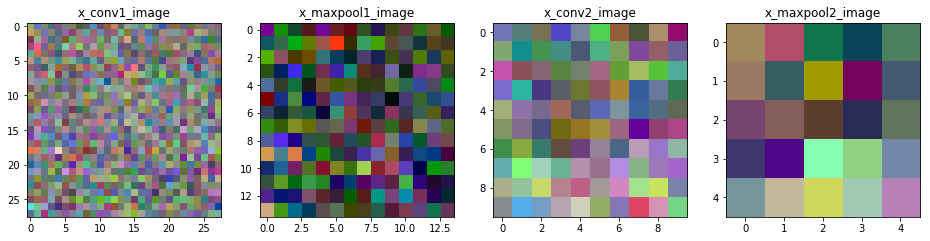

In [62]:
input = Variable(torch.randn(1, 3, 32, 32)) #定义一个随机输入
test_run(input)

Test_Net(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=264627, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)
264627


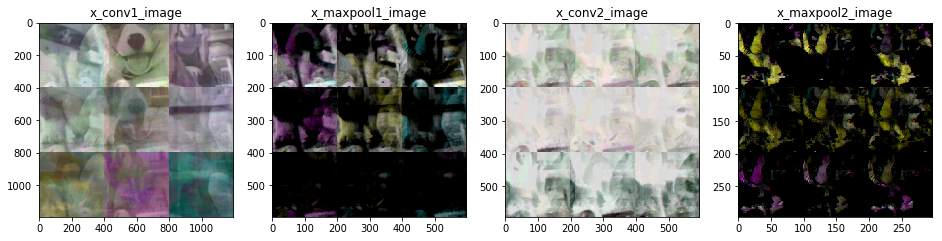

In [65]:
test_run(Dog)

# 引入真实的数据集进行训练

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

## 导入数据集

In [12]:
#标准化图像
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#导入训练集，加载训练集，对其进行分batch
#定义了一个类
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

#导入验证集，加载验证集，进行分batch
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
#torch.utils.data.DataLoader 是提供了所有上述特点的迭代器. 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [13]:
print(trainset,'\n',type(trainset),'\n', type(trainloader))
print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None 
 <class 'torchvision.datasets.cifar.CIFAR10'> 
 <class 'torch.utils.data.dataloader.DataLoader'>
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


  dog truck   car  frog


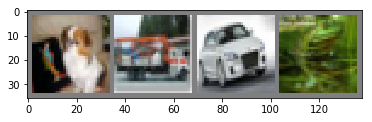

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 定义函数来显示图像

def imshow(img):
    img = img / 2 + 0.5     # 非标准化,将数据规整到0-1之间
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 得到一些随机的训练图像
dataiter = iter(trainloader) #得到一个迭代器
images, labels = dataiter.next() #torch.Size([4, 3, 32, 32]) <class 'torch.Tensor'>

# 显示图像
imshow(torchvision.utils.make_grid(images)) 
#将batch图像转化为网格图像torch.Size([3, 36, 138]):3个通道，
#图片之间存在2个空白像素点

# 输出类别
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
print(images.size(),type(images),torchvision.utils.make_grid(images).shape)

torch.Size([4, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([3, 36, 138])


## 定义一个卷积网络
### 定义一个含有8层的全卷积网络，使用平均池化代替全连接层，做最终的分类，其中第1,3,5,7个卷积用来可视化

In [16]:
 class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层 '1'表示输入图片为单通道, '6'表示输出通道数, '5'表示卷积核为5*5
        # 核心       
        self.conv1 = nn.Conv2d(3, 3, 3, padding = 1)
        self.conv2 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding = 1)
        self.conv4 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv5 = nn.Conv2d(64, 3, 3, padding = 1)
        self.conv6 = nn.Conv2d(3, 128, 3, padding = 1)
        self.conv7 = nn.Conv2d(128, 3, 3, padding = 1)
        self.conv8 = nn.Conv2d(3, 256, 3, padding = 1)
        self.AdaMaxPool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(256, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #在由多个输入平面组成的输入信号上应用2D最大池化.
        # (2, 2) 代表的是池化操作的步幅
        
#         plt.figure(figsize=(16, 14))

        x_conv1 = self.conv1(x)        
        x_conv1 = self.conv2(x_conv1)
        x_maxpool1 = F.max_pool2d(F.relu(x_conv1), 2)
        
        x_conv3 = self.conv3(x_maxpool1)        
        x_conv3 = self.conv4(x_conv3)
        x_maxpool2 = F.max_pool2d(F.relu(x_conv3), 2)
        
        x_conv5 = self.conv5(x_maxpool2)        
        x_conv5 = self.conv6(x_conv5)
        x_maxpool3 = F.max_pool2d(F.relu(x_conv5), 2)
        
        x_conv7 = self.conv7(x_maxpool3)        
        x_conv7 = self.conv8(x_conv7)
        x_maxpool4 = self.AdaMaxPool(F.relu(x_conv7))

        x = x_maxpool4.view(-1, x_maxpool4.size()[1])
        # 仿射层/全连接层: y = Wx + b
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

In [17]:
net = Net()
# net.cuda()
print(net)
# print(net.parameters) #打印模型中的参数

Net(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (AdaMaxPool): AdaptiveMaxPool2d(output_size=1)
  (fc1): Linear(in_features=256, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [18]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net_normal(nn.Module):
    def __init__(self):
        super(Net_normal, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_normal = Net_normal()

In [19]:
#测试模型构建的准确性
input = Variable(torch.randn(1, 3, 32, 32))
net(input)

tensor([[-0.1470, -0.0623, -0.1203, -0.0924, -0.0592,  0.0173,  0.0238, -0.0197,
         -0.0443, -0.1236]], grad_fn=<AddmmBackward>)

## 定义一个损失函数和优化器

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 训练网络

In [21]:
Loss = []
for epoch in range(10):  # 循环遍历数据集多次
    running_loss = 0.0
    print('='*30,'epoch = %d'%epoch,'='*30)
    for i, data in enumerate(trainloader, 0):
        # 得到输入数据
        inputs, labels = data

        # 包装数据
        inputs, labels = Variable(inputs), Variable(labels)

        # 梯度清零
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印信息
        running_loss += loss.data.item()
        if i % 2000 == 1999:    # 每2000个小批量打印一次
            Loss.append(running_loss / 2000)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
print('Finished Training')

============================== epoch = 0 ==============================
[1,  2000] loss: 2.304
[1,  4000] loss: 2.304
[1,  6000] loss: 2.303
[1,  8000] loss: 2.304
[1, 10000] loss: 2.302
[1, 12000] loss: 2.156
============================== epoch = 1 ==============================
[2,  2000] loss: 1.969
[2,  4000] loss: 1.884
[2,  6000] loss: 1.791
[2,  8000] loss: 1.675
[2, 10000] loss: 1.636
[2, 12000] loss: 1.571
============================== epoch = 2 ==============================
[3,  2000] loss: 1.526
[3,  4000] loss: 1.477
[3,  6000] loss: 1.432
[3,  8000] loss: 1.404
[3, 10000] loss: 1.409
[3, 12000] loss: 1.371
============================== epoch = 3 ==============================
[4,  2000] loss: 1.328
[4,  4000] loss: 1.321
[4,  6000] loss: 1.305
[4,  8000] loss: 1.299
[4, 10000] loss: 1.262
[4, 12000] loss: 1.267
============================== epoch = 4 ==============================
[5,  2000] loss: 1.241
[5,  4000] loss: 1.230
[5,  6000] loss: 1.230
[5,  8000] loss: 1.

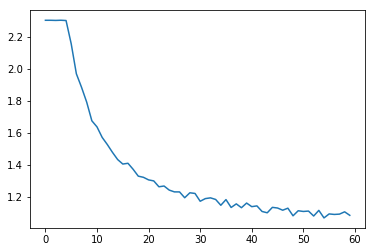

In [22]:
# print(Loss)
plt.plot(Loss)
plt.show()

## 测试一个batch的预测结果

GroundTruth:   frog  frog   car  frog


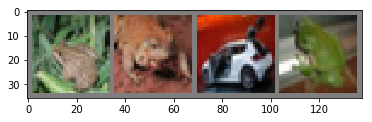

In [66]:
# dataiter = iter(testloader)

images, labels = dataiter.next()

# 打印图像
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [67]:
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  frog   car  bird


## 打印在测试集上的预测准确率

In [26]:
correct = 0
total = 0
C = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

In [28]:
print('Accuracy of the network on the 10000 test images: %d  %%' % (100 * correct / total))
for i in range(10):
    print('Accuracy of %5s : %2d,  %2d, %.3f %%' % (classes[i],  class_correct[i], 
                                                   class_total[i], class_correct[i].data.item()/class_total[i]))
Correct_number = sum([ a.data.item() for a in class_correct])
print('Total correct number: %d, %.4f%%'%(Correct_number, Correct_number/10000))

Accuracy of the network on the 10000 test images: 60  %
Accuracy of plane : 19,  1000, 0.019 %
Accuracy of   car : 142,  1000, 0.142 %
Accuracy of  bird : 56,  1000, 0.056 %
Accuracy of   cat : 87,  1000, 0.087 %
Accuracy of  deer : 146,  1000, 0.146 %
Accuracy of   dog : 156,  1000, 0.156 %
Accuracy of  frog : 113,  1000, 0.113 %
Accuracy of horse : 113,  1000, 0.113 %
Accuracy of  ship : 219,  1000, 0.219 %
Accuracy of truck : 105,  1000, 0.105 %
Total correct number: 1156, 0.1156%


## 保存模型参数

In [29]:
torch.save(net.state_dict(), 'params.pt')
model = torch.load('params.pt')  
# print(model)

## 加入绘图功能后的模型

In [31]:
 class Net_Picture(nn.Module):
    def __init__(self):
        super(Net_Picture, self).__init__()
        # 卷积层 '1'表示输入图片为单通道, '6'表示输出通道数, '5'表示卷积核为5*5
        # 核心       
        self.conv1 = nn.Conv2d(3, 3, 3, padding = 1)
        self.conv2 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding = 1)
        self.conv4 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv5 = nn.Conv2d(64, 3, 3, padding = 1)
        self.conv6 = nn.Conv2d(3, 128, 3, padding = 1)
        self.conv7 = nn.Conv2d(128, 3, 3, padding = 1)
        self.conv8 = nn.Conv2d(3, 256, 3, padding = 1)
        self.AdaMaxPool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(256, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #在由多个输入平面组成的输入信号上应用2D最大池化.
        # (2, 2) 代表的是池化操作的步幅
        
        plt.figure(figsize=(16, 14))

        x_conv1 = self.conv1(x)   
        plt.subplot(141)
        plt.title('x_conv1_image')
        Print_image(x_conv1)
        x_conv1 = self.conv2(x_conv1)
        x_maxpool1 = F.max_pool2d(F.relu(x_conv1), 2)
        
        x_conv3 = self.conv3(x_maxpool1)    
        plt.subplot(142)
        plt.title('x_conv3_image')
        Print_image(x_conv3)
        x_conv3 = self.conv4(x_conv3)
        x_maxpool2 = F.max_pool2d(F.relu(x_conv3), 2)
        
        x_conv5 = self.conv5(x_maxpool2)    
        plt.subplot(143)
        plt.title('x_conv5_image')
        Print_image(x_conv5)
        x_conv5 = self.conv6(x_conv5)
        x_maxpool3 = F.max_pool2d(F.relu(x_conv5), 2)
        
        x_conv7 = self.conv7(x_maxpool3)        
        plt.subplot(144)
        plt.title('x_conv7_image')
        Print_image(x_conv7)
        x_conv7 = self.conv8(x_conv7)
        x_maxpool4 = self.AdaMaxPool(F.relu(x_conv7))

        x = x_maxpool4.view(-1, x_maxpool4.size()[1])
        # 仿射层/全连接层: y = Wx + b
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

In [32]:
Picture_model = Net_Picture()
print(Picture_model)

Net_Picture(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (AdaMaxPool): AdaptiveMaxPool2d(output_size=1)
  (fc1): Linear(in_features=256, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## 测试数据集中的数据

## 导入参数前的测试

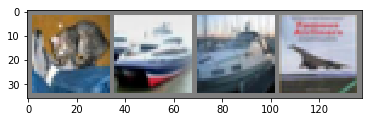

GroundTruth:    cat  ship  ship plane


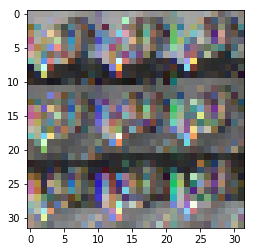

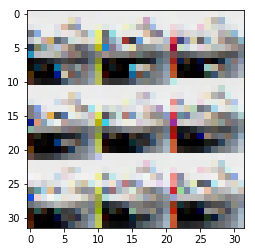

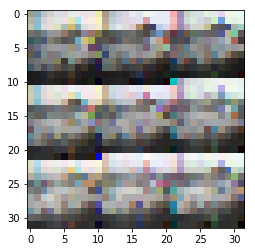

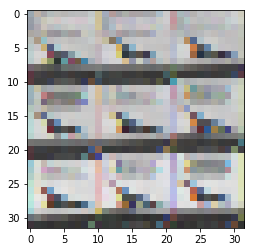

GroundTruth:    cat  ship  ship plane


In [33]:
dataiter = iter(testloader)

images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
plt.show()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# 打印图像
for i in range(4):
    a = images[i].reshape(images[i].shape[::-1])
    plt.imshow(a/2+0.5)
    plt.show()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Predicted:   ship
Predicted:   ship
Predicted:   ship
Predicted:   ship


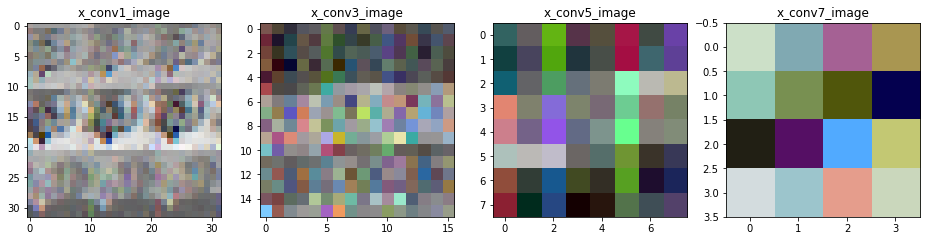

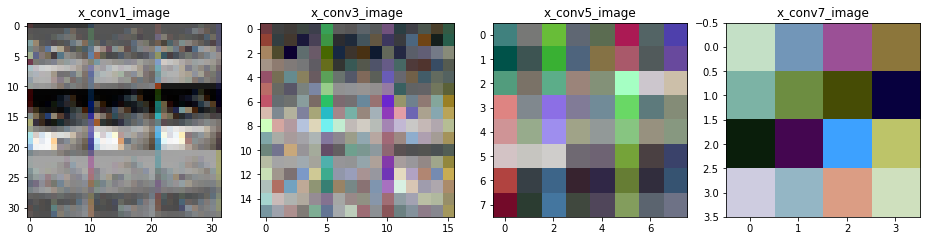

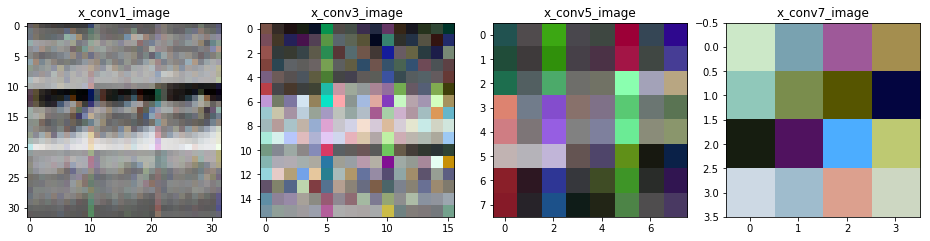

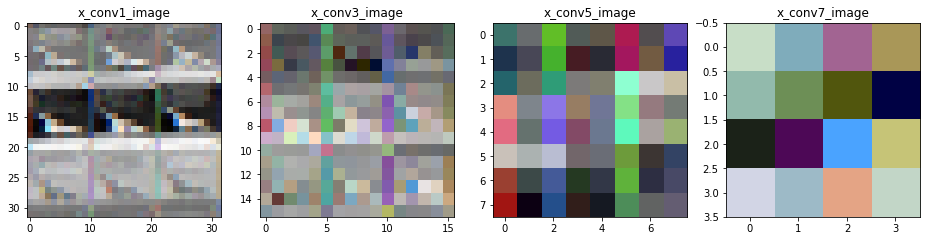

In [34]:
for i in range(4):  
    outputs = Picture_model(Variable(images[i].reshape(1,3,32,32)))
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted: ', '%5s' % classes[predicted])

## 导入参数

In [35]:
Picture_model.load_state_dict(torch.load('params.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## 导入参数后的测试

GroundTruth:    cat  ship  ship plane
Predicted:    cat
Predicted:  plane
Predicted:   ship
Predicted:  plane


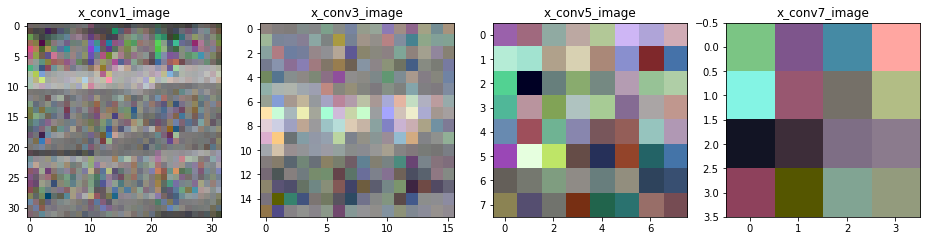

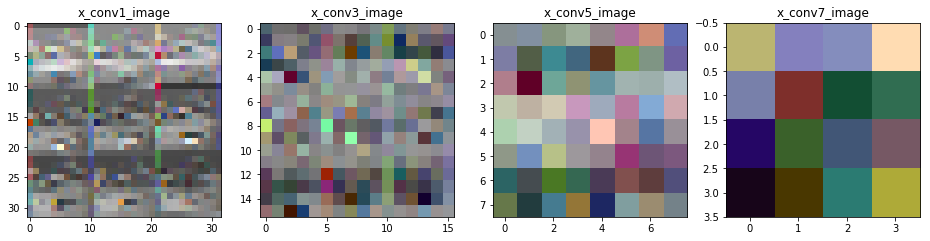

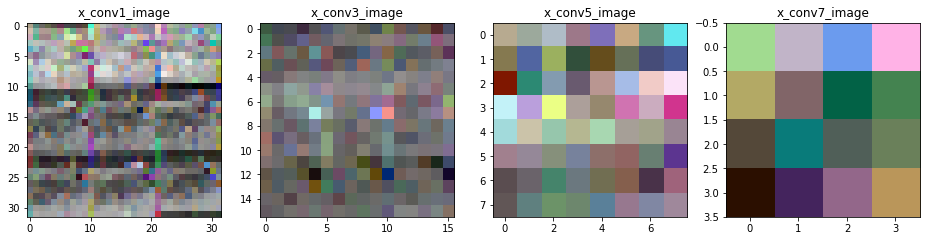

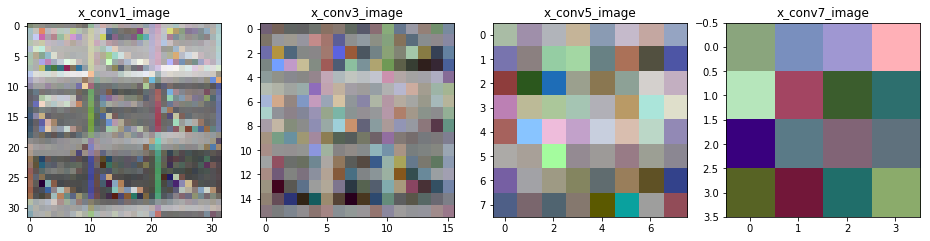

In [36]:
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
for i in range(4):  
    outputs = Picture_model(Variable(images[i].reshape(1,3,32,32)))
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted: ', '%5s' % classes[predicted])

## 测试自己的图片

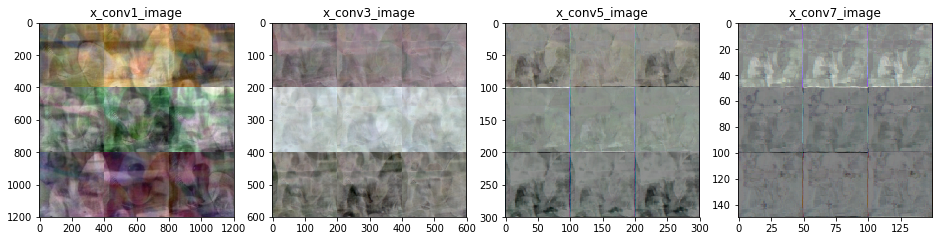

In [37]:
Output = Picture_model(Dog)

In [38]:
_, predicted = torch.max(Output.data, 1)

print('Predicted: ', '%5s' % classes[predicted])

Predicted:  truck


## 改变图片的大小:1200 X 1200-->32 X 32

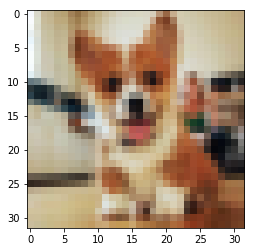

In [39]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


def readImage(path, size=32):
    mode = Image.open(path)
    transform1 = transforms.Compose([
        transforms.Resize (size),
        transforms.CenterCrop((size, size)),
        transforms.ToTensor()
    ])
    mode = transform1(mode)
    return mode


def showTorchImage(image):
    mode = transforms.ToPILImage()(image)
    plt.imshow(mode)
    plt.show()

Example_Picture = readImage('timg.jpg',size=32)
showTorchImage(Example_Picture)

Predicted:    dog


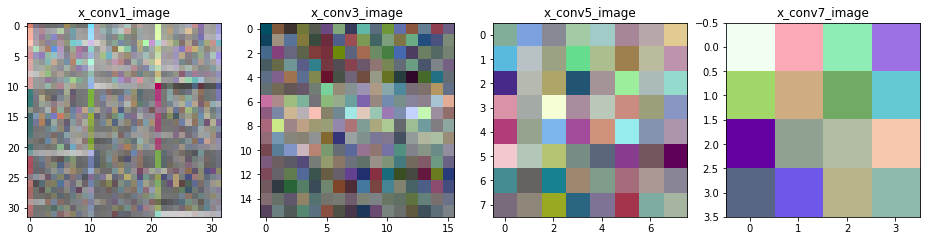

In [40]:
Dog_resize = torch.FloatTensor(Example_Picture.reshape([1]+list(Example_Picture.shape)))
Output = Picture_model(Dog_resize)
_, predicted = torch.max(Output.data, 1)
print('Predicted: ', '%5s' % classes[predicted])

In [41]:
torch.__version__

'1.1.0'